# Test to assess whether ROH caller works as intended
Run ROH caller on known test cases to assess whether the caller behaves as expected.
Contains various test cases.

In [1]:
### Some Code to set right paths on Harald's Machine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os as os
import sys as sys
import multiprocessing as mp
import sys
import socket as socket

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

### If wanting to use local version and not  pip installed version
#sys.path.append("./package/") # Append local Hapsburg Folder
sys.path.insert(0,"./package/")  # hack to get local package first in path
from hapsburg.PackagesSupport.hapsburg_run import hapsb_ind, hapsb_chrom  # Need this import

midway2-0402.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [2]:
##############################################
### Helper Functions for tests

def check_max_roh(path_roh_file, roh_max=(0.05,0.1)):
    """Check if file at path_roh_file has 
    maximum roh in roh_max [array of size 2, Morgan]"""
    df =  pd.read_csv(path_roh_file)
    m = np.max(df["lengthM"])
    as_should= (roh_max[0]<m<roh_max[1])
    return as_should

##############################################

def test_chromosome_roh():
    """Do a testrun for one chromosome with known ROH (ca. 15 cM).
    Test hapROH function hapsb_ind"""
    path_roh_file = "./Empirical/Eigenstrat/Example/I1178/chr20/roh.csv"
    ### Delete the exisiting ROH file
    if os.path.exists(path_roh_file):
        os.remove(path_roh_file)

    hapsb_ind(iid="I1178", chs=range(20, 21), 
              path_targets='./Data/ExampleData/Levant_ChL', # The path before the .ind, .snp, .geno
              h5_path1000g='./Data/1000Genomes/HDF5/1240kHDF5/all1240int8/chr', 
              meta_path_ref='./Data/1000Genomes/Individuals/meta_df_all.csv', 
              folder_out='./Empirical/Eigenstrat/Example/', prefix_out='', 
              e_model='haploid', p_model='Eigenstrat', 
              post_model='Standard', processes=1, delete=False, output=True, save=True, 
              save_fp=False, n_ref=2504, exclude_pops=[], readcounts=False, random_allele=True, 
              roh_in=1, roh_out=20, roh_jump=300, e_rate=0.01, e_rate_ref=0.0, 
              cutoff_post=0.999, max_gap=0, roh_min_l=0.01, 
              logfile=False, combine=False, file_result='_roh_full.csv')
    
    ### Load the ROH file
    m =check_max_roh(path_roh_file, roh_max=(0.14,0.17)) # should be 15.87 cM
    assert(m)    
    print(f"\nTest Passed!")
    return 0

##############################################
### Test Individual ROH Caller

def test_individual_roh(procs=6):
    """Test running indiviudal, combining and multiprocessing.
    procs: How many Processors to use"""
    ### Delete old files
    for ch in range(1,23):
        path_roh_file = f"./Empirical/Eigenstrat/Example/I1178/chr{ch}/roh.csv"
        if os.path.exists(path_roh_file):
            os.remove(path_roh_file)
            print(f"Deleted {path_roh_file}")
            
    path_full = "./Empirical/Eigenstrat/Example/I1178_roh_full.csv"
    if os.path.exists(path_full):
        os.remove(path_full)
        print(f"Deleted {path_full}")
    
    hapsb_ind(iid="I1178", chs=range(1,23), processes=procs, 
          path_targets='./Data/ExampleData/Levant_ChL', 
          h5_path1000g='./Data/1000Genomes/HDF5/1240kHDF5/all1240int8/chr', 
          meta_path_ref='./Data/1000Genomes/Individuals/meta_df_all.csv', 
          folder_out='./Empirical/Eigenstrat/Example/', prefix_out='', 
          e_model="haploid", p_model="Eigenstrat",
          random_allele=True, readcounts=False,
          delete=False, logfile=True, combine=True)
    
    ### Now load the data again (to check that part)
    df =  pd.read_csv(path_full)
    df_long = df[df["lengthM"]>0.04]
    s_roh = np.sum(df_long["lengthM"])
    assert(6<s_roh<8)
    print(f"\n Test passed!")
    return 0

##############################################
### Test Individual ROH Caller

def test_X_IBD():
    """Do a testrun for one chromosome with known ROH (ca. 15 cM).
    Test hapROH function hapsb_ind"""
    path_roh_file = "/project2/jnovembre/hringbauer/HAPSBURG/Empirical/dumpster/testx/I15965_I16171/chr23/roh.csv"
    ### Delete the exisiting ROH file
    if os.path.exists(path_roh_file):
        os.remove(path_roh_file)

    hapsb_chrom(iid=["I15965","I16171"], ch=23, save=True, save_fp=False, n_ref=2504, diploid_ref=False, exclude_pops=[],
                e_model='readcount', p_model='EigenstratX', readcounts=True, random_allele=False,
                post_model="IBD_X", logfile=False, 
                path_targets = "/project2/jnovembre/hringbauer/caribbean_roh/data/eigenstrat/v421_CaribIllu1000GancSam_bySite_PAM",
                h5_path1000g = "/project2/jnovembre/hringbauer/HAPSBURG/Data/1000Genomes/HDF5/1240kHDF5/all1240/chr", 
                meta_path_ref = "/project2/jnovembre/hringbauer/HAPSBURG/Data/1000Genomes/Individuals/meta_df_all_sex.tsv",
                folder_out = "/project2/jnovembre/hringbauer/HAPSBURG/Empirical/dumpster/testx/")
    
    ### Load the ROH file
    m =check_max_roh(path_roh_file, roh_max=(0.35,0.38))
    assert(m)
    print(f"\nTest Passed!")
    return 0

# Run the tests
Print "test passed" in the end and functions return 0 if test was successful

### Single Chromsome with long ROH.
Using Individual I1178. Run ROH analysis for chromosome 20.
Save results in folder, then load them and check if long ROH block is there as should.

In [3]:
%%time
test_chromosome_roh()

Doing Individual I1178...
Running 1 total jobs; 1 in parallel.
Using Low-Mem Cython Linear Speed Up.
Loaded Pre Processing Model: Eigenstrat
Loading Individual: I1178

Loaded 29078 variants
Loaded 2504 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/all1240int8/chr20.hdf5
Eigenstrat packed: True
3 Eigenstrat Files with 22 Individuals and 1233013 SNPs

Intersection on Positions: 29078
Nr of Matching Refs: 29078 / 29078
Ref/Alt Matching: 29053 / 29078
Flipped Ref/Alt Matching: 0
Together: 29053 / 29078
2504 / 2504 Individuals included in Reference
Extracting up to 2504 Individuals
Extraction of 5008 Haplotypes complete
Flipping Ref/Alt Alleles in target for 0 SNPs...
Reduced to markers called 19815 / 29053
Fraction SNPs covered: 0.6820
Successfully saved target individual data to: ./Empirical/Eigenstrat/Example/I1178/chr20/
Shuffling phase of target...
Successfully loaded Data from: ./Empirical/Eigenstrat/Example/I1178/chr20/
Loaded Emission Model: haploid
Loaded Transitio

0

# Whole individual
Run indiivudal I1178. Takes aboout 5 minutes with 6 processes.

In [4]:
%%time
test_individual_roh(procs=6)

Deleted ./Empirical/Eigenstrat/Example/I1178/chr1/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr2/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr3/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr4/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr5/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr6/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr7/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr8/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr9/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr10/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr11/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr12/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr13/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr14/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr15/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr16/roh.csv
Deleted ./Empirical/Eigenstrat/Example/I1178/chr17/roh.csv
Delete

0

# Call IBD on male X Chromosomes
Test IBD Calls between two male X chromosomes

In [5]:
%%time
test_X_IBD()

Using Low-Mem Cython Linear Speed Up.
Loaded Pre Processing Model: EigenstratX
Loading Individual: ['I15965', 'I16171']

Loaded 47898 variants
Loaded 2504 individuals
HDF5 loaded from /project2/jnovembre/hringbauer/HAPSBURG/Data/1000Genomes/HDF5/1240kHDF5/all1240/chrX.hdf5
Eigenstrat packed: True
3 Eigenstrat Files with 1488 Individuals and 1233013 SNPs

Intersection on Positions: 47895
Nr of Matching Refs: 9790 / 47895
Ref/Alt Matching: 9772 / 47895
Flipped Ref/Alt Matching: 37994
Together: 47766 / 47895
2504 / 2504 Individuals included in Reference
Extracting up to 2504 Individuals
Extraction of 2504 Haplotypes complete
Flipping Ref/Alt Alleles in target for 37994 SNPs...
Reduced to markers called 21264 / 47766
Fraction SNPs covered: 0.4452
Successfully saved target individual data to: /project2/jnovembre/hringbauer/HAPSBURG/Empirical/dumpster/testx/I15965_I16171/chr23/
Loading Readcounts...
Mean Readcount markers loaded: 1.42019
Successfully loaded Data from: /project2/jnovembre/hri

0

# Test plotting functions
Essentially just check whether they run without error and produce the desired output

In [6]:
from hapsburg.figures.plot_posterior import plot_posterior_cm
from hapsburg.figures.plot_individual_roh import plot_roh_individual, plot_pde_indivdiual

In [7]:
def test_plot_posterior():
    plot_posterior_cm(folder = "./Empirical/Eigenstrat/Example/I1178/chr6/", savepath="", title="I1178, Chr. 6", 
                      empirical=True, m=2, cm_lim=[], min_cm=4, 
                      groundtruth = False, readcount=False, figsize=(10,4))
    print(f"\nTest Passed!")
    return 0


def test_plot_roh_individual():
    plot_roh_individual(iid="I1178", savepath="", folder="./Empirical/Eigenstrat/Example/", title="",
                        min_cm=4, plot_bad=False, prefix_out="", gap=0.5, output=False) 
    print(f"\nTest Passed!")
    return 0

def test_plot_pde_individual():
    plot_pde_indivdiual(iid='I1178', min_cm=4, snp_cm=50, bw_cm=4, kde_plot=False, 
                        plotlim=[4, 100], savepath='', folder='./Empirical/Eigenstrat/Example/', 
                        prefix_out='', output=False, gap=0.5)
    print(f"\nTest Passed!")
    return 0

Successfully loaded Data from: ./Empirical/Eigenstrat/Example/I1178/chr6/


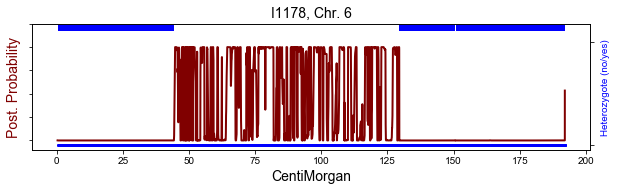


Test Passed!


0

In [8]:
test_plot_posterior()

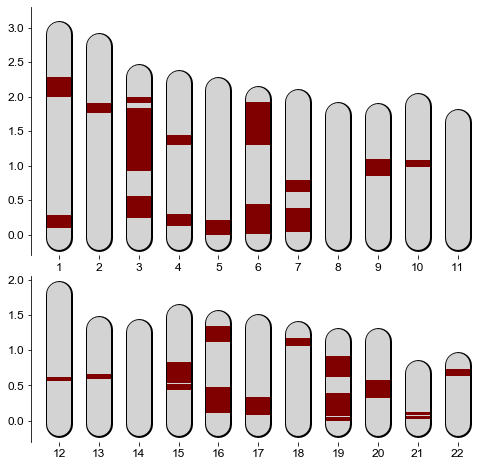


Test Passed!


0

In [9]:
test_plot_roh_individual()

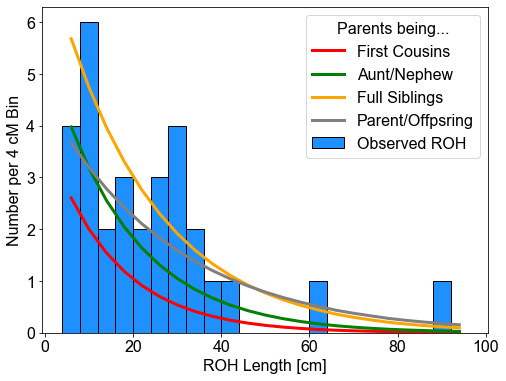


Test Passed!


0

In [10]:
test_plot_pde_individual()